In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"
# model1name = "Bonzanni2013"
# model2name = "Krumsiek2011"
merged_prob_name =  model1name + "_" + model2name

In [2]:
from rpy2.robjects.packages import importr
boolnet = importr("BoolNet")
from rpy2.robjects.pandas2ri import rpy2py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
# To increase the IOPub data rate limit, for the Markov simulation
!jupyter notebook --NotebookApp.iopub_data_rate_limit=20000000

[I 2024-06-07 18:38:08.225 ServerApp] jupyter_lsp | extension was successfully linked.
[I 2024-06-07 18:38:08.230 ServerApp] jupyter_server_terminals | extension was successfully linked.
[W 2024-06-07 18:38:08.232 LabApp] 'iopub_data_rate_limit' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
[W 2024-06-07 18:38:08.235 ServerApp] ServerApp.iopub_data_rate_limit config is deprecated in 2.0. Use ZMQChannelsWebsocketConnection.iopub_data_rate_limit.
[I 2024-06-07 18:38:08.236 ServerApp] jupyterlab | extension was successfully linked.
[I 2024-06-07 18:38:08.240 ServerApp] notebook | extension was successfully linked.
[I 2024-06-07 18:38:08.495 ServerApp] notebook_shim | extension was successfully linked.
[I 2024-06-07 18:38:08.513 ServerApp] notebook_shim | extension was successfully loaded.
[I 2024-06-07 18:38:08.515 ServerApp] jupyter_lsp | extension was successfully loaded.
[I 2024-06-07 18:38:08.51

In [3]:
def read_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    # Skip the first line if it's a header (starts with 'target')
    if lines[0].startswith('targets'):
        lines = lines[1:]
    # Create a dictionary where each gene is a key and its rule is a value
    data = {}
    for line in lines:
        parts = line.strip().split(',')
        if len(parts) < 2:
            continue
        gene, rule = parts[0], ','.join(parts[1:]).strip()
        data[gene] = rule
    return data

def combine_files(file1, file2):
    # Read both files
    data1 = read_file(file1)
    data2 = read_file(file2)

    # All unique genes
    all_genes = set(data1.keys()).union(data2.keys())
    result = []

    for gene in all_genes:
        if gene in data1 and gene in data2:
            # Gene in both files, write two lines
            result.append(f'{gene},{data1[gene]},0.5')
            result.append(f'{gene},{data2[gene]},0.5')
        elif gene in data1:
            # Gene only in first file
            result.append(f'{gene},{data1[gene]},1')
        elif gene in data2:
            # Gene only in second file
            result.append(f'{gene},{data2[gene]},1')

    return result
    
def write_result(result, output_file):
    with open(output_file, 'w') as file:
        file.write('targets, factors\n')
        for line in result:
            file.write(f'{line}\n')
            
file1_path = "./Models/" + model1name + '.txt'
file2_path = "./Models/" + model2name + '.txt'
output_file_path = "./Models/merged_Prob_" + merged_prob_name + '.txt'

# Combine and write the result
combined_data = combine_files(file1_path, file2_path)
write_result(combined_data, output_file_path)

In [4]:
# Load the PBN
net = boolnet.loadNetwork("./Models/merged_Prob_" + merged_prob_name + ".txt")
print(net)

Probabilistic Boolean network with 50 genes

Involved genes:
HOXA9 ROS1 MEIS1 CCNE1 BCL2 RB1 PRO_APOPTOTIC_PROTEINS EXTERNAL_QUIESCENCE MTOR DIFFERENTIATION MDM2 MYC TSC1 E2F1 FLT3 TP53 EXTERNAL_CYCLING STAT5A ETV6 AKT1 ANTI_APOPTOTIC_PROTEINS GFI1 FBXW7 CDKN2D AUTOPHAGY FOXO3 S_PHASE CTNNB1 SENESCENCE CCND1 MEFV CDKN2A NRAS ETS1 CEBPA APOPTOSIS CDKN1A CDKN1B ATM DNMT3A NPM1 MITOCHONDRIA PIK3CA PROLIFERATION CYCS SOX4 MAPK1 GSK3B CDKN1C BMI1

Transition functions:

Alternative transition functions for gene HOXA9:
HOXA9 = !NPM1 ( probability: 1)

Alternative transition functions for gene ROS1:
ROS1 = MITOCHONDRIA | !ATM | !FOXO3 | !BMI1 | !TP53 ( probability: 1)

Alternative transition functions for gene MEIS1:
MEIS1 = HOXA9 & !DNMT3A ( probability: 1)

Alternative transition functions for gene CCNE1:
CCNE1 = (!CDKN1C) & ((!CDKN1A & !CDKN1B) | CCND1) & (E2F1) ( probability: 1)

Alternative transition functions for gene BCL2:
BCL2 = MAPK1 & !TP53 ( probability: 1)

Alternative transition

In [5]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Enable the automatic conversion between R and pandas dataframes
pandas2ri.activate()


# Define the custom R function within Python
ro.r('''
markovSimulation_custom <- function(network, numIterations=1000, startStates=list(), cutoff=0.001, returnTable=TRUE) {
    if (sum(network$fixed == -1) > 32) {
        warning("More than 32 non-fixed genes detected! Proceeding with the simulation but results may be unreliable.")
    }

    # Determine if the network is deterministic or probabilistic
    if (inherits(network,"BooleanNetwork")) {
        inputGenes <- as.integer(unlist(lapply(network$interactions,function(interaction)interaction$input)))
        inputGenePositions <- as.integer(cumsum(c(0,sapply(network$interactions, function(interaction)length(interaction$input)))))
        transitionFunctions <- as.integer(unlist(lapply(network$interactions,function(interaction)interaction$func)))
        transitionFunctionPositions <- as.integer(cumsum(c(0,sapply(network$interactions, function(interaction)length(interaction$func)))))
        probabilities <- as.double(rep(1.0,length(network$genes)))
        functionAssignment <- as.integer(0:(length(network$genes)-1))
    } else {
        wrongProb <- sapply(network$interactions,function(interaction)
            abs(1.0-sum(sapply(interaction,function(func)func$probability))) > 0.0001)
        if (any(wrongProb))
            stop(paste("The probabilities of gene(s) ",paste(network$genes[wrongProb],collapse=", ")," do not sum up to 1!",sep=""))
        
        inputGenes <- as.integer(unlist(lapply(network$interactions,function(interaction)lapply(interaction,function(singleFunc)singleFunc$input))))
        inputGenePositions <- as.integer(cumsum(c(0,unlist(lapply(network$interactions, function(interaction)lapply(interaction,function(singleFunc)length(singleFunc$input)))))))
        transitionFunctions <- as.integer(unlist(lapply(network$interactions,function(interaction)lapply(interaction,function(singleFunc)singleFunc$func))))
        transitionFunctionPositions <- as.integer(cumsum(c(0,unlist(lapply(network$interactions, function(interaction)lapply(interaction,function(singleFunc)length(singleFunc$func)))))))
        probabilities <- as.double(unlist(lapply(network$interactions,function(interaction)lapply(interaction,function(singleFunc)singleFunc$probability))))
        functionAssignment <- as.integer(unlist(mapply(function(index,interaction)rep(index,length(interaction)),0:(length(network$interactions )- 1), network$interactions)))
    }

    fixedGenes <- which(network$fixed != -1)
    if (length(startStates) > 0) {
        statesValid <- sapply(startStates,function(state) {
            isTRUE(all(state[fixedGenes] == network$fixed[fixedGenes]))
        })
        if (!isTRUE(all(statesValid)))
            warning("Some of the supplied start states did not match the restrictions of the fixed genes and were removed!")
        startStates <- startStates[statesValid]
    }

    convertedStartStates <- NULL
    if (length(startStates) > 0)
        convertedStartStates <- sapply(startStates,function(x)bin2dec(x,length(network$genes)))

    on.exit(.C("freeAllMemory", PACKAGE = "BoolNet"))

    res <- .Call("markovSimulation_R",
        inputGenes,inputGenePositions,
        transitionFunctions,transitionFunctionPositions,
        as.integer(network$fixed),
        functionAssignment,
        probabilities,
        as.integer(numIterations),
        convertedStartStates,
        as.double(cutoff),
        as.integer(returnTable),
        PACKAGE="BoolNet")

    if (length(network$genes) %% 32 == 0)
        numElementsPerEntry <- as.integer(length(network$genes) / 50)
    else
        numElementsPerEntry <- as.integer(length(network$genes) / 50  + 1)

    reachedStates <- data.frame(t(sapply(res$states,function(state)dec2bin(state,length(network$genes)))),res$probabilities)
    colnames(reachedStates) <- c(network$genes,"Probability")

    if (returnTable) {
        initialStates <- matrix(res$initialStates,nrow=numElementsPerEntry)
        nextStates <- matrix(res$nextStates,nrow=numElementsPerEntry)
        res <- list(reachedStates=reachedStates,
                    table=list(initialStates=initialStates,nextStates=nextStates,probabilities=res$transitionProbabilities),
                    genes=network$genes)
    } else {
        res <- list(reachedStates=reachedStates,
                    table=NULL,
                    genes=network$genes)
    }

    class(res) <- "MarkovSimulation"
    return(res)
}
''')

def markov_simulation(network, num_iterations=1000, start_states=None, cutoff=0.001, return_table=True):
    if start_states is None:
        start_states = ro.ListVector([])

    # Get the custom R function
    r_markov_simulation = ro.globalenv['markovSimulation_custom']

    # Call the custom R function
    result = r_markov_simulation(network, numIterations=num_iterations, startStates=start_states, cutoff=cutoff, returnTable=return_table)
    
    return result

In [ ]:
# perform a Markov chain simulation
sim = markov_simulation(net)

In [5]:
# convert R/rpy2 DataFrame to pd
df = rpy2py(sim[0])
df

TAL1,EGR1,SMAD6,...,CEBPA,HHEX,Probability
0,0,0,...,0,0,0.210560
1,0,0,,0,0,0.394720
1,0,0,,0,0,0.394720


In [37]:
# Define the order of columns as in the paper
column_order_1 = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1']
column_order_2 = ['GATA1', 'GATA2', 'ZFPM1', 'TAL1', 'SPI1', 'FLI1','KLF1','CEBPA','GFI1','NAB1','EGR2','JUN','EGR1']
column_order_merged = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1', 'KLF1','CEBPA','GFI1','NAB1','EGR2','JUN','EGR1']

# Model1 results
df1 = pd.read_csv("./SimulationResults/attr_" + model1name + ".csv", index_col = 0)
df1.index = df1.index.str.replace('S', 'B')
df1 = df1[column_order_1]

# Model2 results
df2 = pd.read_csv("./SimulationResults/attr_" + model2name + ".csv", index_col = 0)
df2.index = df2.index.str.replace('S', 'K')
df2 = df2[column_order_2]

# Merged results
df.index = ["M" + str(i) for i in range(1, 1+len(df))]
df_prob = df[column_order_merged]
df_prob = pd.concat([df_prob, df1, df2])

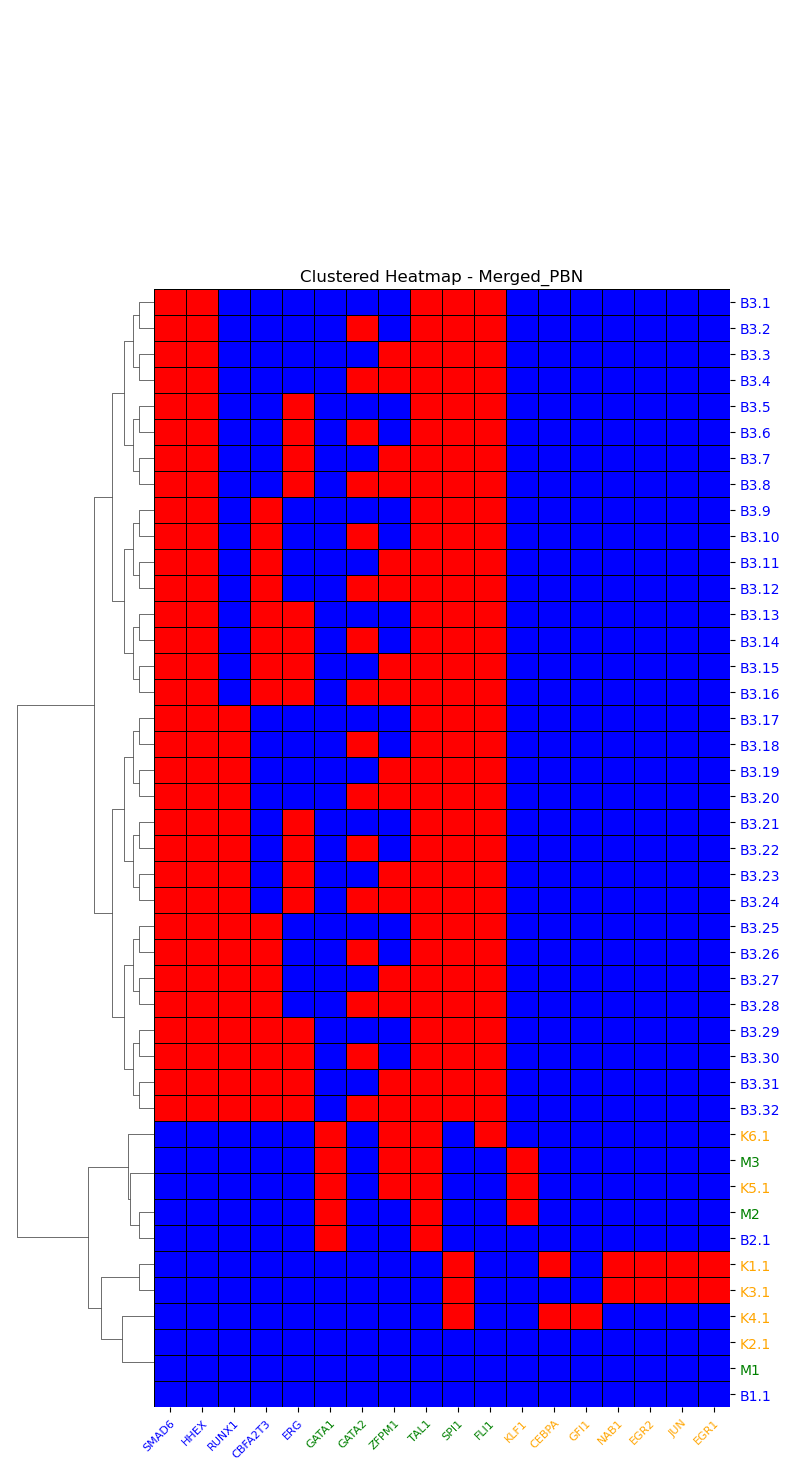

In [38]:
# Visualize
cmap = ListedColormap(['blue', 'red'])
g = sns.clustermap(df_prob.fillna(0), method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(8, 15), cbar=False, col_cluster=False)
g.ax_heatmap.set_title('Clustered Heatmap - Merged_PBN')
g.ax_heatmap.tick_params(axis='y', labelsize=10) 
g.ax_heatmap.tick_params(axis='x', labelsize=8)  
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels for better readability
g.cax.set_visible(False)

# Determine the color based on the label text
def get_ylabel_color(label):
    if label.startswith('B'):
        return 'blue'
    elif label.startswith('K'):
        return 'orange'
    elif label.startswith('M'):
        return 'green'
    else:
        return 'black'  # Default color
        
def get_xlabel_color(label):
    if label in set(column_order_merged) - set(column_order_1):
        return 'orange'
    elif label in set(column_order_merged) - set(column_order_2):
        return 'blue'
    else:
        return 'green'
        
# Set the color of labels based on their text
for label in g.ax_heatmap.get_yticklabels():
    label.set_color(get_ylabel_color(label.get_text()))
for label in g.ax_heatmap.get_xticklabels():
    label.set_color(get_xlabel_color(label.get_text()))
plt.show()

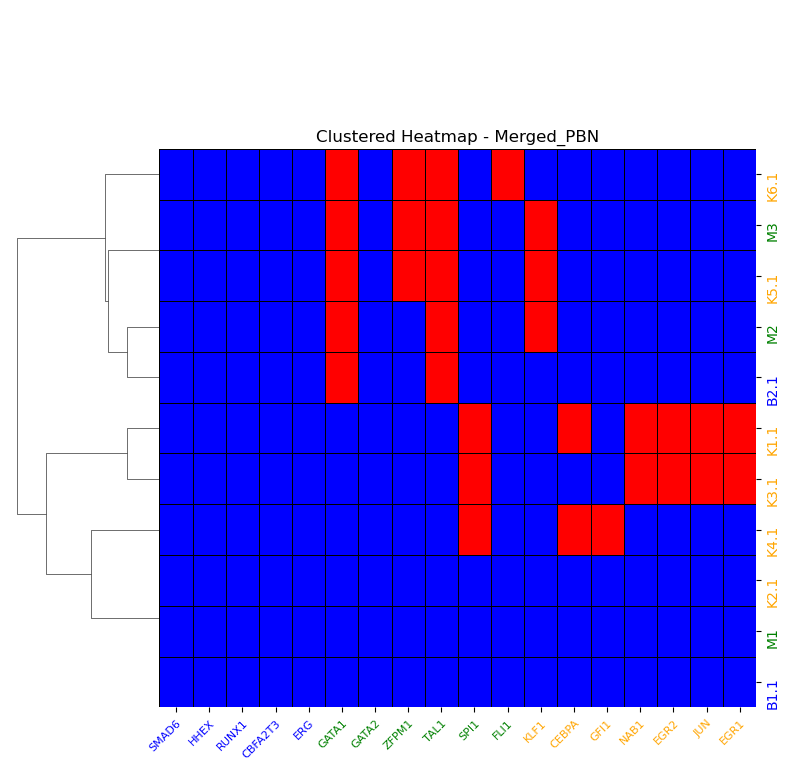

In [36]:
# Model1 results
df1 = pd.read_csv("./SimulationResults/attr_" + model1name + "_simple.csv", index_col = 0)
df1.index = df1.index.str.replace('S', 'B')
df1 = df1[column_order_1]

# Model2 results
df2 = pd.read_csv("./SimulationResults/attr_" + model2name + ".csv", index_col = 0)
df2.index = df2.index.str.replace('S', 'K')
df2 = df2[column_order_2]

# Merged results
df.index = ["M" + str(i) for i in range(1,1+len(df))]
df_prob = df[column_order_merged]
df_prob = pd.concat([df_prob, df1, df2])

# Visualize
cmap = ListedColormap(['blue', 'red'])
g = sns.clustermap(df_prob.fillna(0), method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(8, 8), cbar=False, col_cluster=False)
g.ax_heatmap.set_title('Clustered Heatmap - Merged_PBN')
g.ax_heatmap.tick_params(axis='y', labelsize=10) 
g.ax_heatmap.tick_params(axis='x', labelsize=8)  
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels for better readability
g.cax.set_visible(False)

# Determine the color based on the label text
def get_ylabel_color(label):
    if label.startswith('B'):
        return 'blue'
    elif label.startswith('K'):
        return 'orange'
    elif label.startswith('M'):
        return 'green'
    else:
        return 'black'  # Default color
        
def get_xlabel_color(label):
    if label in set(column_order_merged) - set(column_order_1):
        return 'orange'
    elif label in set(column_order_merged) - set(column_order_2):
        return 'blue'
    else:
        return 'green'
        
# Set the color of labels based on their text
for label in g.ax_heatmap.get_yticklabels():
    label.set_color(get_ylabel_color(label.get_text()))
for label in g.ax_heatmap.get_xticklabels():
    label.set_color(get_xlabel_color(label.get_text()))
plt.show()

In [40]:
df

,TAL1,EGR1,SMAD6,SPI1,NAB1,GATA1,JUN,ZFPM1,RUNX1,EGR2,FLI1,GATA2,ERG,KLF1,GFI1,CBFA2T3,CEBPA,HHEX,Probability
M1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.21056
M2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.39472
M3,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0.39472
